**Generative Adversarial Networks (GAN) for Image Creation**

GAN is a method of pairing a network that is meant to produce a fake or simulation of an image, or a piece of text or some other output with a detector which is trained to tell the difference between a fake output from the generator and a real data point.

The portion that produces the simulation or fake is called the *generator*, while the portion that tries to spot fakes is called the *detector*.

The two are trained together as a part in a competive or *adversial* fashion 

This allows the system to learn to generate convincing fakes or simulations.

This is a complex pair models,   the setting is for a high performance GPU,  use this setting if you have compute points left in Google Colab

https://www.analyticsvidhya.com/blog/2021/06/a-detailed-explanation-of-gan-with-implementation-using-tensorflow-and-keras/

In [27]:
import tensorflow as tf
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras.layers import LeakyReLU, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras import initializers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from tensorflow.keras.utils import plot_model

from matplotlib import pyplot
import numpy as np
from math import sqrt

In [3]:
# diagnostic, checking to be sure the CPU is working

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#version check

tf.__version__

'2.12.0'

Load the mnist fashion data set

In [4]:
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)


Create a function that will generate a set of random images as starting points

We will be training the generator image to take a random image of the right size and convert it into an image that will appear to be one of the valid MNIST Fashion images

In [5]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

Define a function that will Generate a set of randomly picked items from the X_train data set

In [6]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

Generate a set of random images,  using the random starting values,

then create an image from this random image using the generator model

(We haven't defined the generator yet)

In [7]:
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [8]:
# function to summarize peformance, saving the model to disk

In [9]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(100):
        pyplot.subplot(10, 10, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s' % (filename2))

In [10]:
def save_plot(examples, n_examples):
    for i in range(n_examples):
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

Construct the discriminator, that classifies images as real or false

We will be building the model in two sections the generator and the discriminator

The discriminator is just a classic image classifier,   it is using dropout, but not using any convolution layers, so this isn't a really high performance model

In [11]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0001, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [12]:
discriminator = define_discriminator()

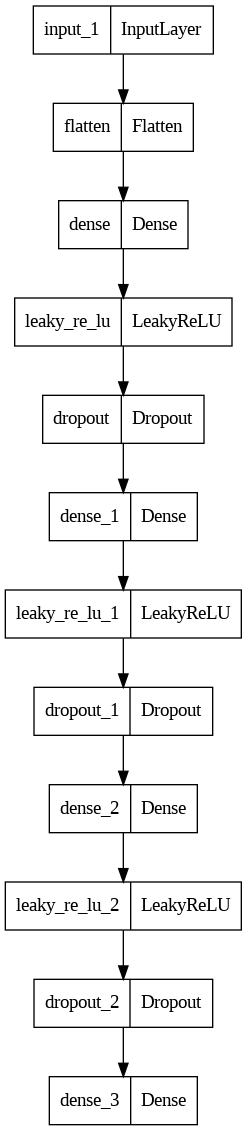

In [28]:
# I added this model plot to the notebook after running it,  while annotating the notebook
# this plot may not run until after the model has been trained

plot_model(discriminator)

Create the generator to try to create fake images successfully,from 100 random values

The latent dim is number of values used in creating the random image

The image created is reshaped into 28,28,1 images,   which is what the discriminator is looking for as an input

In [13]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [14]:
generator = define_generator(100)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


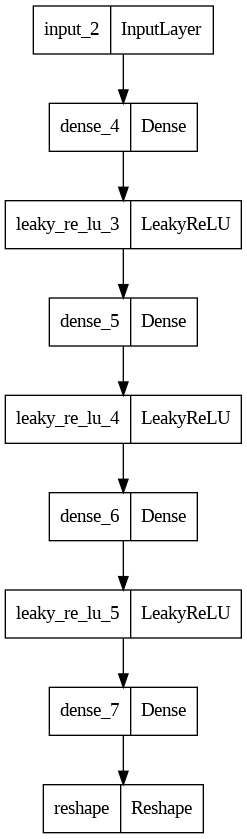

In [29]:
# I added this model plot to the notebook after running it,  while annotating the notebook
# this plot may not run until after the model has been trained

plot_model(generator)

Set up the gan model,  comprised by the generator and discriminator in sequence

The discriminator in this model is frozen, not allowed to change

if we use the gan model,   and train it, we will be altering only the generator, not the discriminator

That will mean a training loop on the gan_model improves only the generator

In [15]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
gan_model = define_gan(generator, discriminator)

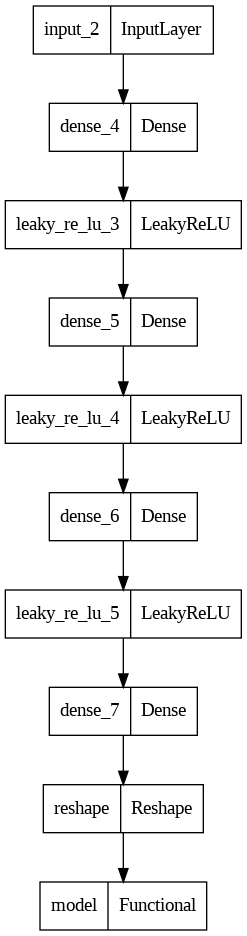

In [30]:
plot_model(gan_model)

**Here is the training process**

This is not a standard model fitting procedure, but a customized loop to carry out this adversarial training process.  It trains one batch at time for each model, so there are 3 training steps per batch

Here is what the steps in the loop are doing

-generate real samples

-train the discriminator on real samples for this step

       d_loss, d_acc-  ability of discriminator to identify true samples,    
       should increas initially, then fall as the generator gets better

-generate some fake samples using the generator

-train the discriminator on the fake samples

      df_loss, df_acc- ability of discriminator to identify fakes  -should 
      fall as the run continues

-train the entire model (gan_model) on Z_input random data, with the labels set to one and the discriminator frozen,  thus training the generator to trick the discriminator,  during this step only the generator is trained.

     g_loss, gdf- should fall then raise toward 50%,   it is the odds of  
     fooling the discriminator

At the end of each Epoch, the model will be save to disk and the performance calculation shown
    

In [34]:

def train(g_model, d_model, gan_model, X_train, latent_dim, n_epochs=5, n_batch=32):
    bat_per_epo = int(X_train.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_real, y_real = generate_real_samples(X_train, n_batch)
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        
        # fakes labeled as fake, train the discriminator to spot these
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake)
        
        #fakes now labeled as real
        z_input = generate_latent_points(latent_dim, n_batch) 
        y_gan = ones((n_batch, 1)) 
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        
      #  z_input = generate_latent_points(latent_dim, n_batch) 
      #  y_gan = ones((n_batch, 1)) 
      #  g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)
        
        
        if(i%200==0):
            print()
            print("Loss & Accuracy Levels")
            print('Discrim on real >%d, dr[%.3f,%.3f], Discrim on Fake df[%.3f,%.3f], Generator g[%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))
            print()
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

8/8 [==============================] - 0s 2ms/step

Loss & Accuracy Levels
Discrim on real >1, dr[0.612,0.586], Discrim on Fake df[0.661,0.695], Generator g[0.932,0.102]

8/8 [==============================] - 0s 2ms/step

Loss & Accuracy Levels
Discrim on real >201, dr[0.696,0.520], Discrim on Fake df[0.655,0.699], Generator g[1.055,0.047]

4/4 [==============================] - 0s 3ms/step


>Saved: model_0234.h5
8/8 [==============================] - 0s 2ms/step

Loss & Accuracy Levels
Discrim on real >401, dr[0.630,0.555], Discrim on Fake df[0.660,0.699], Generator g[0.929,0.164]

4/4 [==============================] - 0s 3ms/step


>Saved: model_0468.h5
8/8 [==============================] - 0s 2ms/step

Loss & Accuracy Levels
Discrim on real >601, dr[0.666,0.590], Discrim on Fake df[0.711,0.602], Generator g[0.877,0.168]

4/4 [==============================] - 0s 3ms/step


>Saved: model_0702.h5
8/8 [==============================] - 0s 2ms/step

Loss & Accuracy Levels
Discrim on real >801, dr[0.699,0.434], Discrim on Fake df[0.631,0.719], Generator g[0.954,0.145]

4/4 [==============================] - 0s 3ms/step


>Saved: model_0936.h5
CPU times: user 1min 49s, sys: 5.66 s, total: 1min 54s
Wall time: 2min 3s


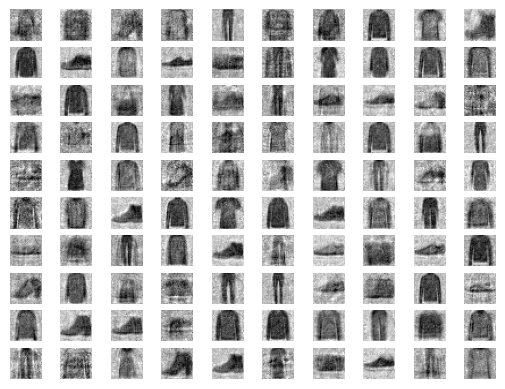

In [35]:
%%time
latent_dim = 100
train(generator, discriminator, gan_model, X_train, latent_dim, n_epochs=4, n_batch=256)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 22ms/step


array([[0.2204085]], dtype=float32)

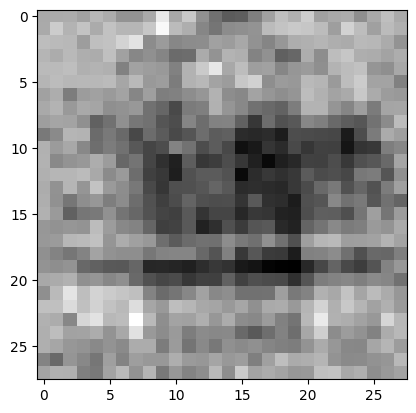

In [36]:
target_model='/content/model_1872.h5'

modelr = load_model(target_model)
latent_dim = 100
n_examples = 1
latent_points = generate_latent_points(latent_dim, n_examples)


X  = modelr.predict(latent_points)

pyplot.imshow(X[0,:,:,0],cmap='gray_r')

discriminator.predict(X)

1/1 [==============================] - 0s 19ms/step


array([[0.28332075]], dtype=float32)

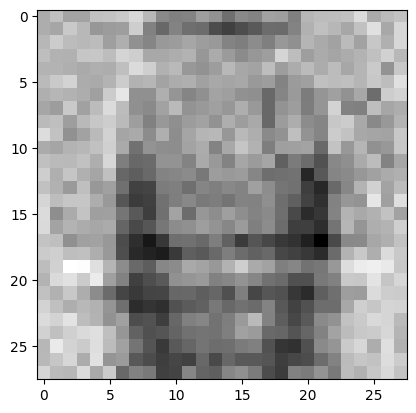

In [40]:
latent_points = generate_latent_points(latent_dim, n_examples)


X  = modelr.predict(latent_points)

pyplot.imshow(X[0,:,:,0],cmap='gray_r')

discriminator.predict(X)